<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.datasets import boston_housing, fashion_mnist

from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(123)

In [52]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [54]:
scaler = PowerTransformer() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tested a few scalers, not convinced they make a lot of difference
#
# X_train = tf.keras.utils.normalize(X_train, order=10)
# X_test  = tf.keras.utils.normalize(X_test, order=10)

# Same result: from sklearn.preprocessing import Normalizer
# scaler = Normalizer() 
# X_train = normalizer.fit_transform(X_train)

In [55]:
model = Sequential(name="Boston_Housing")

model.add(Dense(24, input_dim=13, activation='relu'))
model.add(Dense(16))
model.add(LeakyReLU(alpha=0.05))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam',
              metrics=['mse','mae','mape'])

model.summary()

Model: "Boston_Housing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 24)                336       
_________________________________________________________________
dense_33 (Dense)             (None, 16)                400       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [56]:
%%time
housing = model.fit(X_train, y_train, epochs=500, validation_split=0.1, verbose=False)
scores = model.evaluate(X_test, y_test)
print(f"{model.metrics_names[1]}: {scores[1]}")

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [12]:
# housing.history

{'loss': [579.9357488122525,
  546.5886223743113,
  500.1647675989745,
  432.11509969411804,
  337.42028732930333,
  231.8406447313377,
  141.65625765041216,
  95.23637264031024,
  88.41632479412824,
  87.69136884915271,
  85.72561618184912,
  84.41629192257716,
  83.5798507669412,
  82.64236668778517,
  81.43818738112437,
  80.48486466841264,
  79.49152821942795,
  78.69236488972814,
  77.69328188305059,
  76.75097069858519,
  75.62676919984423,
  75.00976354425603,
  73.77947917129055,
  72.86537757852517,
  72.16276301496941,
  71.3921036891044,
  70.57812680751496,
  70.04933633094977,
  69.44815056120397,
  68.95004724865117,
  68.24886525366917,
  67.6583198778557,
  67.39082781473796,
  66.66175342065901,
  66.47874942495804,
  66.14057872971884,
  65.8053613457798,
  65.2509466123975,
  64.9733029305114,
  64.80530704676941,
  64.50788295104812,
  64.2818057688143,
  64.11854658836175,
  63.5067856213278,
  63.89718331581305,
  63.51728842343837,
  63.38556063733482,
  62.81052

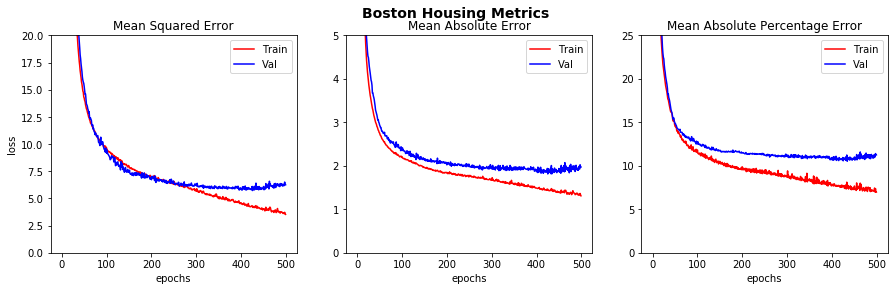

In [67]:
# Brush up my MatPlotLib!

fig, ((ax1,ax2,ax3)) = plt.subplots(nrows=1,ncols=3,sharey=False,figsize=(15,4))
fig.suptitle('Boston Housing Metrics', fontsize=14, fontweight='bold')

ax1.plot(housing.history['mse'], color = 'r', label='Train')
ax1.plot(housing.history['val_mse'], color = 'b', label='Val')
ax1.legend()
ax1.set_ylim(0,20)
ax1.set(title='Mean Squared Error', xlabel='epochs', ylabel='loss')

ax2.plot(housing.history['mae'], color = 'r', label='Train')
ax2.plot(housing.history['val_mae'], color = 'b', label='Val')
ax2.set_ylim(0,5)
ax2.legend()
ax2.set(title='Mean Absolute Error', xlabel='epochs', ylabel='')

ax3.plot(housing.history['mape'], color = 'r', label='Train')
ax3.plot(housing.history['val_mape'], color = 'b', label='Val')
ax3.set_ylim(0,25)
ax3.legend()
ax3.set(title='Mean Absolute Percentage Error', xlabel='epochs', ylabel='');

In [68]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print('Mean squared error on test data: ', mse_lr)
print('Mean absolute error on test data: ', mae_lr)

Mean squared error on test data:  20.84489873640473
Mean absolute error on test data:  3.2843004782692864


In [69]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)

print('Mean squared error on test data: ', mse_dt)
print('Mean absolute error on test data: ', mae_dt)

Mean squared error on test data:  24.258137254901964
Mean absolute error on test data:  3.4049019607843136


## Feature Engineering


0. - CRIM - per capita crime rate by town
1. - ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
2. - INDUS - proportion of non-retail business acres per town.
3. - CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
4. - NOX - nitric oxides concentration (parts per 10 million)
5. - RM - average number of rooms per dwelling
6. - AGE - proportion of owner-occupied units built prior to 1940
7. - DIS - weighted distances to five Boston employment centres
8. - RAD - index of accessibility to radial highways
9. - TAX - full-value property-tax rate per $10,000

9. - PTRATIO - pupil-teacher ratio by town
10. - B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
11. - LSTAT - % lower status of the population
12. - MEDV - Median value of owner-occupied homes in $1000's

### Feature Engineering

Will have to wait ...

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# Hyper Parameters
batch_size = 128
num_classes = 10
epochs = 20

In [4]:
X_train[0].shape

(28, 28)

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
# Reshape the data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [7]:
# X Variable Types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# Correct Encoding on Y
# What softmax expects = [0,0,0,0,0,1,0,0,0,0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [97]:
y_train[8]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [98]:
fmnist_model = Sequential()

# Input => Hidden
fmnist_model.add(Dense(16, input_dim=784, activation='relu'))
# Hidden
fmnist_model.add(Dense(16))
fmnist_model.add(LeakyReLU(alpha=0.05))
# Hidden
fmnist_model.add(Dense(16, activation='relu'))
# Output
fmnist_model.add(Dense(num_classes,activation='softmax'))

#Compile
fmnist_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy',
                             'categorical_accuracy',
                             'cosine_proximity'])

fmnist_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_45 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_47 (Dense)             (None, 10)                170       
Total params: 13,274
Trainable params: 13,274
Non-trainable params: 0
_________________________________________________________________


In [99]:
y_test.shape

(10000, 10)

In [100]:
%%time
fashion = fmnist_model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=False)
scores = fmnist_model.evaluate(X_test, y_test)
print(f'{fmnist_model.metrics_names[1]}: {scores[1]*100}')

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [84]:
# fashion.history

{'loss': [1.822812128667478,
  0.7396652279606571,
  0.6683780539389009,
  0.6132096735989606,
  0.5671450412185104,
  0.5422732815300977,
  0.5308214321489687,
  0.5134713535043929,
  0.5059389394919077,
  0.4965411575370365,
  0.4921480395882218,
  0.48747847757516083,
  0.4781684916107743,
  0.47848114237078915,
  0.4747193350791931,
  0.47060793190532263,
  0.4626243659125434,
  0.4583842633476964,
  0.4581238443939774,
  0.45270120509465533,
  0.45187081087960135,
  0.4498213586012522,
  0.4496791795183111,
  0.4480532816162816,
  0.4428568787486465,
  0.4434076011357484,
  0.43745045291052925,
  0.4372600150108337,
  0.441404260246842,
  0.43513393017097757,
  0.43309299204084606,
  0.43265344247994597,
  0.43329154049908675,
  0.43293816386328804,
  0.4285113182067871,
  0.4278363766581924,
  0.425883440679974,
  0.4260787042335228,
  0.4234898050184603,
  0.4259373909544062,
  0.4221946656880555,
  0.4178932471451936,
  0.4222223630922812,
  0.41937434933362183,
  0.41833330365

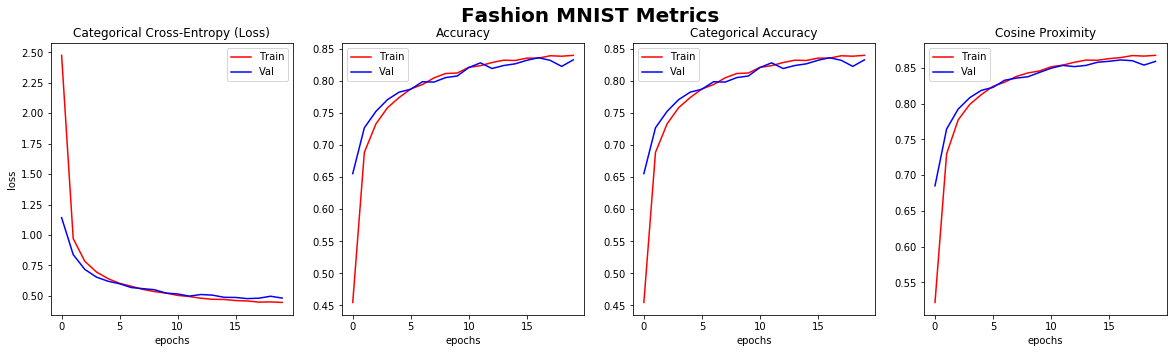

In [101]:
# Brush up my MatPlotLib!

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(nrows=1,ncols=4,sharey=False,figsize=(20,5))
fig.suptitle('Fashion MNIST Metrics', fontsize=20, fontweight='bold')

ax1.plot(fashion.history['loss'], color = 'r', label='Train')
ax1.plot(fashion.history['val_loss'], color = 'b', label='Val')
ax1.legend()
ax1.set(title='Categorical Cross-Entropy (Loss)', xlabel='epochs', ylabel='loss')

ax2.plot(fashion.history['accuracy'], color = 'r', label='Train')
ax2.plot(fashion.history['val_accuracy'], color = 'b', label='Val')
ax2.legend()
ax2.set(title='Accuracy', xlabel='epochs', ylabel='')

ax3.plot(fashion.history['categorical_accuracy'], color = 'r', label='Train')
ax3.plot(fashion.history['val_categorical_accuracy'], color = 'b', label='Val')
ax3.legend()
ax3.set(title='Categorical Accuracy', xlabel='epochs', ylabel='')

ax4.plot(fashion.history['cosine_proximity'], color = 'r', label='Train')
ax4.plot(fashion.history['val_cosine_proximity'], color = 'b', label='Val')
ax4.legend()
ax4.set(title='Cosine Proximity', xlabel='epochs', ylabel='');

### Dropout Regularization

In [9]:
fmnist_model = Sequential()

# Hidden
fmnist_model.add(Dense(16, input_dim=784, activation='relu'))
fmnist_model.add(Dropout(0.05))
fmnist_model.add(Dense(16))
fmnist_model.add(LeakyReLU(alpha=0.05))
fmnist_model.add(Dropout(0.05))
fmnist_model.add(Dense(16, activation='relu'))
fmnist_model.add(Dropout(0.05))
# Output Layer
fmnist_model.add(Dense(num_classes, activation='softmax'))

fmnist_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy',
                             'categorical_accuracy',
                             'cosine_proximity'])

fmnist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0

In [10]:
fashion = fmnist_model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=False)
scores = fmnist_model.evaluate(X_test, y_test)
print(f'{fmnist_model.metrics_names[1]}: {scores[1]*100}')

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

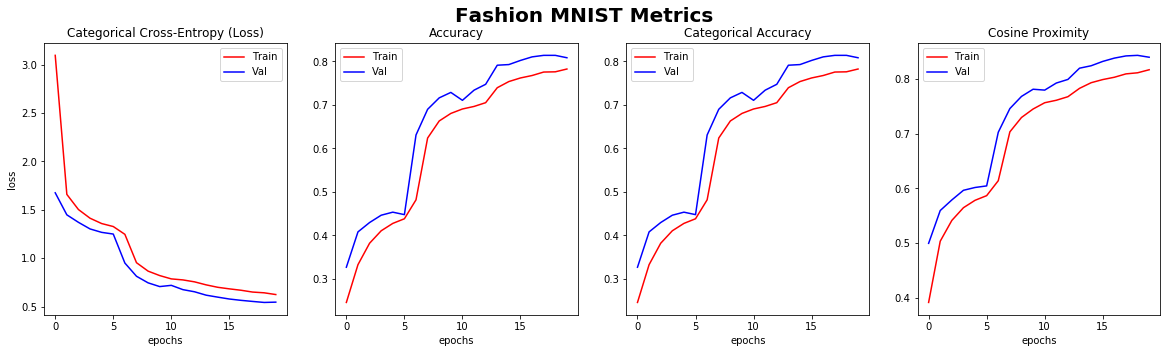

In [11]:
# Brush up my MatPlotLib!

fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(nrows=1,ncols=4,sharey=False,figsize=(20,5))
fig.suptitle('Fashion MNIST Metrics', fontsize=20, fontweight='bold')

ax1.plot(fashion.history['loss'], color = 'r', label='Train')
ax1.plot(fashion.history['val_loss'], color = 'b', label='Val')
ax1.legend()
ax1.set(title='Categorical Cross-Entropy (Loss)', xlabel='epochs', ylabel='loss')

ax2.plot(fashion.history['accuracy'], color = 'r', label='Train')
ax2.plot(fashion.history['val_accuracy'], color = 'b', label='Val')
ax2.legend()
ax2.set(title='Accuracy', xlabel='epochs', ylabel='')

ax3.plot(fashion.history['categorical_accuracy'], color = 'r', label='Train')
ax3.plot(fashion.history['val_categorical_accuracy'], color = 'b', label='Val')
ax3.legend()
ax3.set(title='Categorical Accuracy', xlabel='epochs', ylabel='')

ax4.plot(fashion.history['cosine_proximity'], color = 'r', label='Train')
ax4.plot(fashion.history['val_cosine_proximity'], color = 'b', label='Val')
ax4.legend()
ax4.set(title='Cosine Proximity', xlabel='epochs', ylabel='');

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.